In [52]:
#Module 1 
from pathlib import Path
import os
import random
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

DATA_DIR = Path(r'D:\datasets')  # <-- CHANGE THIS

CLASSES = ["puffy eyes", "wrinkles", "dark spots", "clear skin"]


In [3]:
#Image count per class
counts = {}

for cls in CLASSES:
    folder = DATA_DIR / cls
    counts[cls] = len(list(folder.glob("*.*")))

counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=["count"])
counts_df


,count
puffy eyes,219
wrinkles,245
dark spots,264
clear skin,180


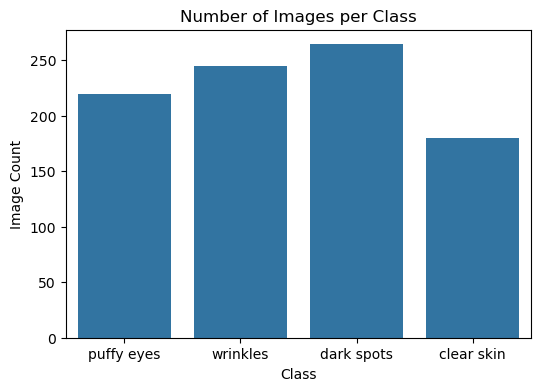

In [4]:
plt.figure(figsize=(6,4))
sns.barplot(x=counts_df.index, y=counts_df['count'])
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.show()


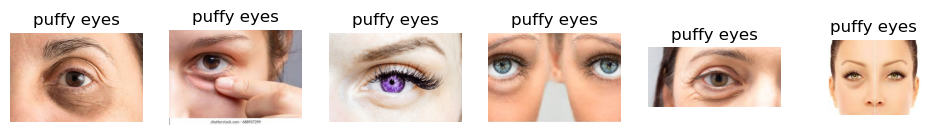

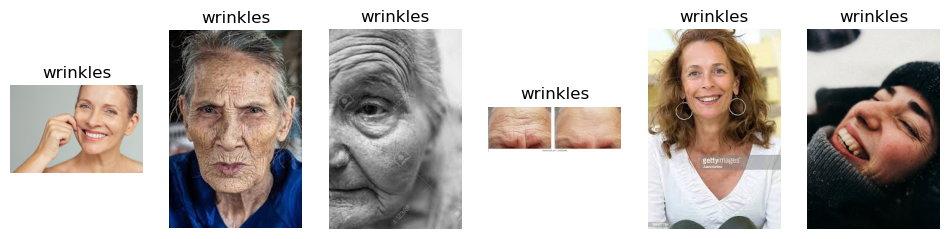

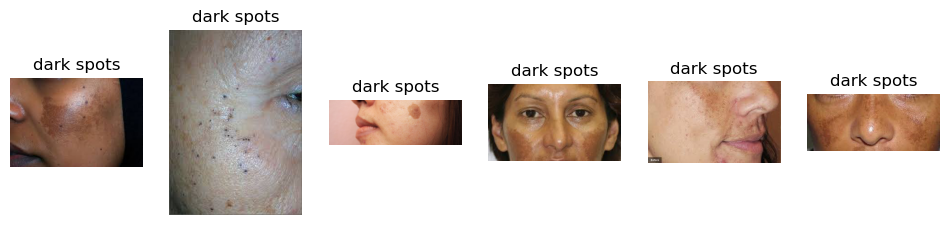

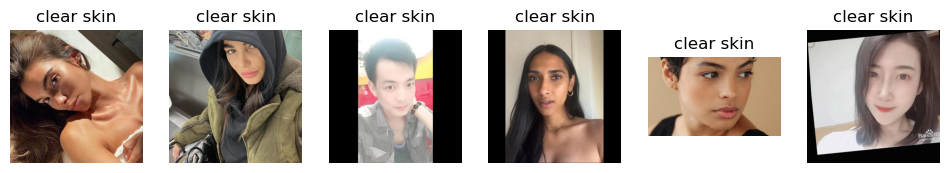

In [19]:
#Sample image grids
def show_samples(cls, n=6):
    folder = DATA_DIR / cls
    paths = list(folder.glob("*.*"))
    sample = random.sample(paths, min(n, len(paths)))

    plt.figure(figsize=(12,3))
    for i, img_path in enumerate(sample, 1):
        img = Image.open(img_path)
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)
    plt.show()

for cls in CLASSES:
    show_samples(cls)


In [20]:
#Image size distribution
widths = []
heights = []
labels = []

for cls in CLASSES:
    for path in (DATA_DIR/cls).glob("*.*"):
        try:
            img = Image.open(path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            labels.append(cls)
        except:
            pass

df_sizes = pd.DataFrame({
    "class": labels,
    "width": widths,
    "height": heights
})


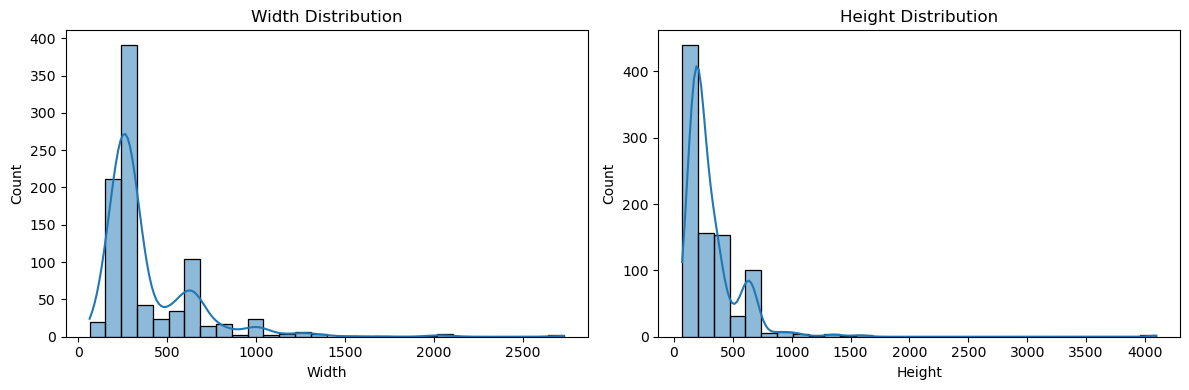

In [22]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df_sizes["width"], kde=True, bins=30)
plt.title("Width Distribution")
plt.xlabel("Width")

plt.subplot(1,2,2)
sns.histplot(df_sizes["height"], kde=True, bins=30)
plt.title("Height Distribution")
plt.xlabel("Height")

plt.tight_layout()
plt.show()


In [23]:
#Brightness distribution
brightness_vals = []
brightness_classes = []

for cls in CLASSES:
    for path in (DATA_DIR/cls).glob("*.*"):
        try:
            img = Image.open(path).convert("L")
            brightness_vals.append(ImageStat.Stat(img).mean[0])  # 0–255
            brightness_classes.append(cls)
        except:
            pass

df_brightness = pd.DataFrame({
    "class": brightness_classes,
    "brightness": brightness_vals
})


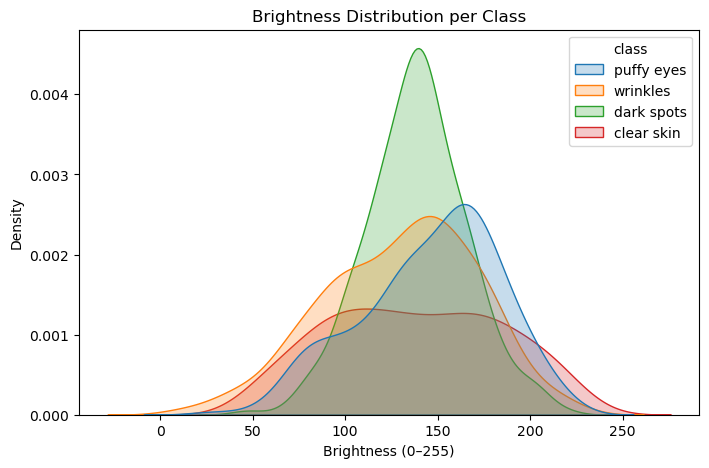

In [24]:
#KDE Plot 
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_brightness, x="brightness", hue="class", fill=True)
plt.title("Brightness Distribution per Class")
plt.xlabel("Brightness (0–255)")
plt.show()


In [25]:
bad_files = []

for cls in CLASSES:
    for p in (DATA_DIR/cls).glob("*.*"):
        try:
            Image.open(p)
        except:
            bad_files.append(p)

print("Corrupt files:", len(bad_files))


Corrupt files: 0


In [41]:
#Module 2
#Preprocess Images (Resize + Normalize)
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random


In [42]:
from pathlib import Path
import numpy as np
from PIL import Image
import tensorflow as tf

DATA_DIR = Path(r'D:\datasets')
CLASSES = ["puffy eyes", "wrinkles", "dark spots", "clear skin"]
IMG_SIZE = (224, 224)

X = []
y = []
OUTPUT_DIR = Path(r'D:\processed')

# Create folder if it doesn't exist
OUTPUT_DIR.mkdir(exist_ok=True)
print("Saving outputs to:", OUTPUT_DIR)



Saving outputs to: D:\processed


In [43]:
for cls in CLASSES:
    folder = DATA_DIR / cls
    label_idx = CLASSES.index(cls)

    for img_path in folder.glob("*.*"):
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMG_SIZE)
            img = np.array(img) / 255.0   # NORMALIZATION
            X.append(img)
            y.append(label_idx)
        except:
            pass


In [44]:
X = np.array(X)
y = tf.keras.utils.to_categorical(y, num_classes=len(CLASSES))

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (908, 224, 224, 3)
y shape: (908, 4)


In [49]:
np.save(OUTPUT_DIR / "X_encoded.npy", X)
np.save(OUTPUT_DIR / "y_encoded.npy", y)

print("Saved preprocessed files to:", OUTPUT_DIR)


Saved preprocessed files to: D:\processed


In [46]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)


In [47]:
augmented_images = []
augmented_labels = []

batch_size = 32
aug_iter = datagen.flow(X, y, batch_size=batch_size)

num_batches = int(len(X) / batch_size)

for _ in range(num_batches):
    batch_x, batch_y = next(aug_iter)
    augmented_images.append(batch_x)
    augmented_labels.append(batch_y)

X_aug = np.concatenate(augmented_images)
y_aug = np.concatenate(augmented_labels)


In [48]:
np.save(OUTPUT_DIR / "X_augmented.npy", X_aug)
np.save(OUTPUT_DIR / "y_augmented.npy", y_aug)

print("Saved augmented files to:", OUTPUT_DIR)


Saved augmented files to: D:\processed


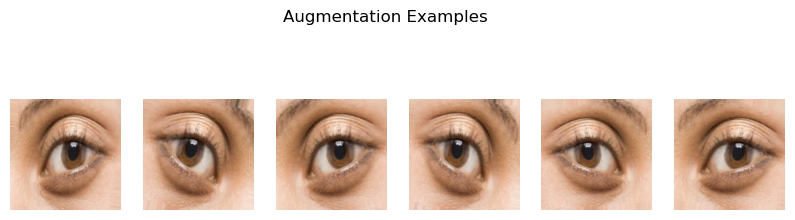

In [50]:
#Generate augmented samples for visualization
sample_img = X[0].reshape(1, 224, 224, 3)

aug_iter = datagen.flow(sample_img, batch_size=1)

plt.figure(figsize=(10,3))
for i in range(6):
    aug_img = next(aug_iter)[0]
    plt.subplot(1,6,i+1)
    plt.imshow(aug_img)
    plt.axis("off")
plt.suptitle("Augmentation Examples")
plt.show()


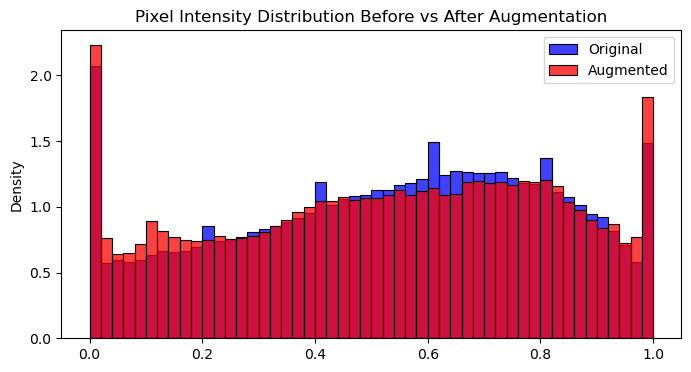

In [51]:
#Augmentation Quality Visualization
plt.figure(figsize=(8,4))
sns.histplot(X.ravel(), bins=50, color="blue", label="Original", stat="density")

aug_batch = datagen.flow(X, y, batch_size=100)
augmented_sample, _ = next(aug_batch)

sns.histplot(augmented_sample.ravel(), bins=50, color="red", label="Augmented", stat="density")

plt.legend()
plt.title("Pixel Intensity Distribution Before vs After Augmentation")
plt.show()


In [53]:
X_final = np.load(r'D:\processed\X_augmented.npy')
y_final = np.load(r'D:\processed\y_augmented.npy')


In [54]:
from sklearn.model_selection import train_test_split
import numpy as np


In [55]:
# First split: training (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y_final, test_size=0.20, random_state=42, stratify=y_final
)

# Second split: validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (716, 224, 224, 3) (716, 4)
Validation: (90, 224, 224, 3) (90, 4)
Test: (90, 224, 224, 3) (90, 4)


In [56]:
OUTPUT_DIR = Path(r'D:\processed')

np.save(OUTPUT_DIR / "X_train.npy", X_train)
np.save(OUTPUT_DIR / "y_train.npy", y_train)

np.save(OUTPUT_DIR / "X_val.npy", X_val)
np.save(OUTPUT_DIR / "y_val.npy", y_val)

np.save(OUTPUT_DIR / "X_test.npy", X_test)
np.save(OUTPUT_DIR / "y_test.npy", y_test)

print("Saved all dataset splits successfully!")


Saved all dataset splits successfully!


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

DATASET_DIR = "/kaggle/input/ai-dermal-dataset-2/datasets"  

classes = sorted(os.listdir(DATASET_DIR))
print("Classes:", classes)


Classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


Class Counts: {'clear skin': 500, 'dark spots': 483, 'puffy eyes': 500, 'wrinkles': 478}


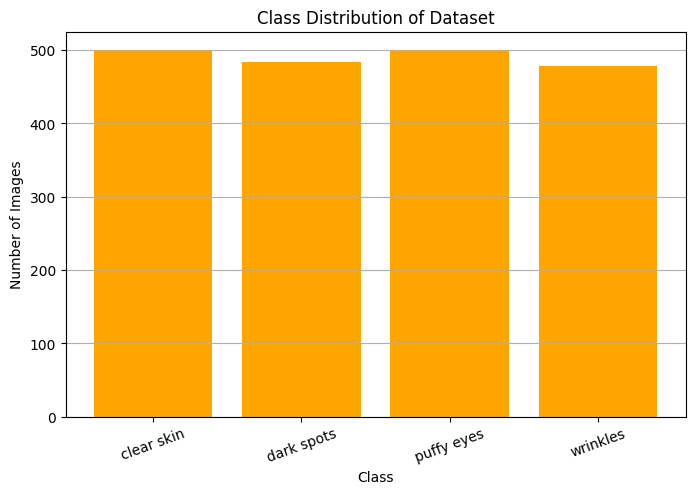

In [3]:
class_counts = {}

for cls in classes:
    class_path = os.path.join(DATASET_DIR, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    class_counts[cls] = len(images)

print("Class Counts:", class_counts)

plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.title("Class Distribution of Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.show()


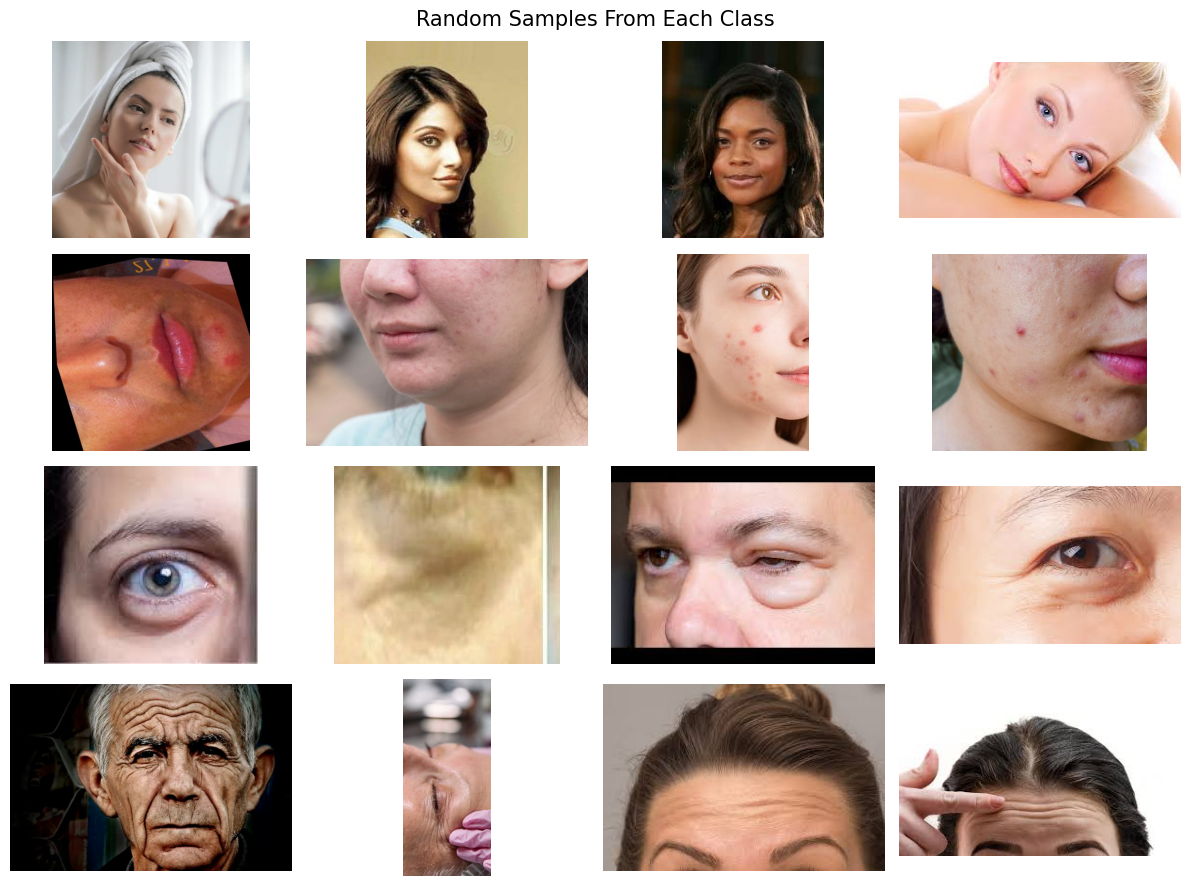

In [4]:
plt.figure(figsize=(12,9))

for i, cls in enumerate(classes):
    
    class_path = os.path.join(DATASET_DIR, cls)
    images = os.listdir(class_path)
    
    sample_images = random.sample(images, min(4, len(images)))
    
    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        plt.subplot(len(classes), 4, i*4 + j + 1)
        plt.imshow(img)
        plt.axis("off")
        
        if j == 0:
            plt.ylabel(cls, fontsize=12)

plt.suptitle("Random Samples From Each Class", fontsize=15)
plt.tight_layout()
plt.show()


In [5]:
from PIL import Image
import pandas as pd

image_info = []

for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)
        try:
            with Image.open(path) as img:
                w,h = img.size
                image_info.append([cls, img_name, w, h])
        except:
            pass

df = pd.DataFrame(image_info, columns=["Class","File","Width","Height"])
df.head(), df.describe()


(        Class                  File  Width  Height
 0  clear skin  clear_skin (142).jpg    200     200
 1  clear skin  clear_skin (119).jpg    300     168
 2  clear skin            195062.jpg    130     218
 3  clear skin            193922.jpg    178     218
 4  clear skin   clear_skin (6).jpeg    225     225,
              Width       Height
 count  1961.000000  1961.000000
 mean    396.686894   358.253442
 std     386.631167   399.561339
 min      60.000000    60.000000
 25%     178.000000   178.000000
 50%     274.000000   218.000000
 75%     500.000000   400.000000
 max    3936.000000  4928.000000)

In [6]:
bad_images = []

for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)
        try:
            img = Image.open(path)
            img.verify()
        except:
            bad_images.append((cls,img_name))

print("Corrupt Images Found:", len(bad_images))
bad_images[:5]


Corrupt Images Found: 0


[]

In [7]:
eye_related = 0

keywords = ["eye","eyes","puffy","under","bag"]

for cls in classes:
    for f in os.listdir(os.path.join(DATASET_DIR, cls)):
        if any(k in f.lower() for k in keywords):
            eye_related += 1

eye_related


344

In [8]:
small_images = []

for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    
    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)
        
        try:
            with Image.open(path) as img:
                w,h = img.size
                if w < 120 or h < 120:
                    small_images.append((cls, img_name, w, h))
        except:
            pass

len(small_images), small_images[:10]


(167,
 [('dark spots', '089c8f6d-60da-46db-931e-9812d35b3599.jpg', 119, 150),
  ('dark spots', '9b4d1032-c4d7-4b30-89ba-523cf69d36ff.jpg', 242, 105),
  ('dark spots', '2ed1ef53-c137-460c-959e-7bf7fe5f4f02.jpg', 112, 197),
  ('puffy eyes', 'puffy_eyes_75.jpg', 158, 119),
  ('puffy eyes', 'puffy_eye_1552.jpg', 238, 116),
  ('puffy eyes', 'puffy_eye_1567.jpg', 238, 88),
  ('puffy eyes', 'puffy_eyes_297.jpg', 275, 107),
  ('puffy eyes', 'puffy_eye_1767.jpg', 204, 81),
  ('puffy eyes', 'puffy_eye_1532.jpg', 71, 78),
  ('puffy eyes', 'puffy_eye_1749.jpg', 140, 62)])

In [9]:
import os
from PIL import Image

removed = 0

for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)

    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)

        try:
            with Image.open(path) as img:
                w,h = img.size

                if w < 120 or h < 120:
                    os.remove(path)
                    removed += 1

        except:
            pass

print("Total images removed:", removed)


Total images removed: 0


In [10]:
import shutil

WORK_DIR = "/kaggle/working/dataset_cleaned"

if not os.path.exists(WORK_DIR):
    shutil.copytree(DATASET_DIR, WORK_DIR)

print("Dataset copied to working directory!")


Dataset copied to working directory!


In [11]:
DATASET_DIR = WORK_DIR
classes = sorted(os.listdir(DATASET_DIR))
classes


['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']

In [12]:
import os
from PIL import Image

removed = 0

for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)

    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)

        try:
            with Image.open(path) as img:
                w,h = img.size
                if w < 120 or h < 120:
                    os.remove(path)
                    removed += 1
        except:
            pass

print("Total images removed:", removed)


Total images removed: 167


In [13]:
tiny_left = 0

for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)

    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)
        with Image.open(path) as img:
            w,h = img.size
            if w < 120 or h < 120:
                tiny_left += 1

tiny_left


0

In [14]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input


In [15]:
DATASET_DIR = "/kaggle/working/dataset_cleaned"
classes = sorted(os.listdir(DATASET_DIR))
classes


['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']

In [16]:
image_paths = []
labels = []

for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    for img in os.listdir(folder):
        image_paths.append(os.path.join(folder, img))
        labels.append(cls)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Total Images:", len(image_paths))
pd.Series(labels).value_counts()


Total Images: 1794


clear skin    500
dark spots    480
wrinkles      416
puffy eyes    398
Name: count, dtype: int64

In [17]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size = 0.2,
    stratify = labels,
    random_state = 42
)

len(train_paths), len(val_paths)


(1435, 359)

In [18]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_df = pd.DataFrame({"filename": train_paths, "class": train_labels})
val_df   = pd.DataFrame({"filename": val_paths, "class": val_labels})


In [20]:
train_gen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=(0.85,1.15),
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [21]:
train_generator = train_gen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_gen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 1435 validated image filenames belonging to 4 classes.
Found 359 validated image filenames belonging to 4 classes.


In [22]:
x, y = next(train_generator)
x.shape


(32, 224, 224, 3)

In [24]:
vis_gen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=(0.85,1.15),
    horizontal_flip=True
)


Found 1435 validated image filenames belonging to 4 classes.


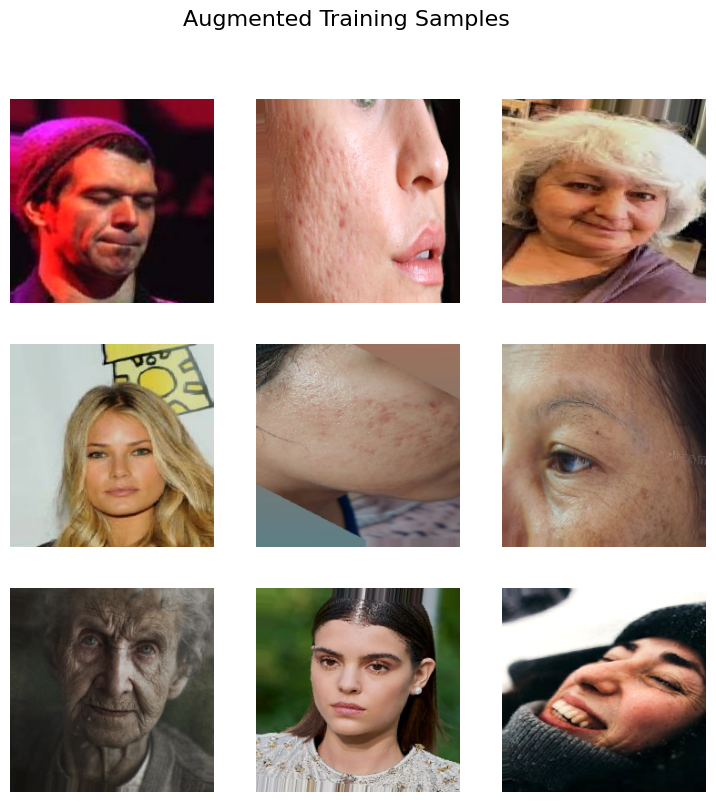

In [25]:
sample = vis_gen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=9,
    shuffle=True
)

imgs, labs = next(sample)

plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i].astype("uint8"))
    plt.axis("off")
plt.suptitle("Augmented Training Samples", fontsize=16)
plt.show()


In [26]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=(0.85,1.15),
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_gen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_gen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 1435 validated image filenames belonging to 4 classes.
Found 359 validated image filenames belonging to 4 classes.


In [27]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

label_map = train_generator.class_indices
y_int = [label_map[l] for l in train_labels]

cw_vals = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_int),
    y=y_int
)

cw = {i: cw_vals[i] for i in range(len(cw_vals))}
cw


{0: 0.896875,
 1: 0.9342447916666666,
 2: 1.1281446540880504,
 3: 1.0773273273273274}

In [28]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

base = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base.input, outputs=output)

model.compile(
    optimizer=Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


I0000 00:00:1766640899.711446      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766640899.712119      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,219,687 (16.10 MB)

 Trainable params: 167,300 (653.52 KB)

 Non-trainable params: 4,052,387 (15.46 MB)

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "DermalScan_EfficientNet.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

early = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.3,
    verbose=1
)


In [30]:
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=cw,
    callbacks=[checkpoint, early, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1766640944.160850     170 service.cc:148] XLA service 0x79887c114620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766640944.161747     170 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766640944.161769     170 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766640946.144120     170 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/45 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.2266 - loss: 2.2435  

I0000 00:00:1766640956.667401     170 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.6101 - loss: 1.1367

45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 984ms/step - accuracy: 0.6127 - loss: 1.1298 - val_accuracy: 0.8663 - val_loss: 0.4578 - learning_rate: 0.0010
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 504ms/step - accuracy: 0.8252 - loss: 0.5072 - val_accuracy: 0.8607 - val_loss: 0.3873 - learning_rate: 0.0010
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8672 - loss: 0.3815

45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 509ms/step - accuracy: 0.8671 - loss: 0.3813 - val_accuracy: 0.8858 - val_loss: 0.3752 - learning_rate: 0.0010
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 495ms/step - accuracy: 0.8934 - loss: 0.2980 - val_accuracy: 0.8830 - val_loss: 0.3356 - learning_rate: 0.0010
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 493ms/step - accuracy: 0.8953 - loss: 0.2864 - val_accuracy: 0.8830 - val_loss: 0.3172 - learning_rate: 0.0010
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 508ms/step - accuracy: 0.9049 - loss: 0.2684 - val_accuracy: 0.8774 - val_loss: 0.3143 - learning_rate: 0.0010
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 502ms/step - accuracy: 0.9059 - loss: 0.2448 - val_accuracy: 0.8830 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9325 - loss: 0.2165

45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 516ms/step - accuracy: 0.9322 - loss: 0.2170 - val_accuracy: 0.8942 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 517ms/step - accuracy: 0.9244 - loss: 0.2042 - val_accuracy: 0.8886 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 523ms/step - accuracy: 0.9263 - loss: 0.2078 - val_accuracy: 0.8886 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - accuracy: 0.9287 - loss: 0.2035 - val_accuracy: 0.8942 - val_loss: 0.2883 - learning_rate: 0.0010
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9315 - loss: 0.2015


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 512ms/step - accuracy: 0.9315 - loss: 0.2015 - val_accuracy: 0.8997 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 13/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step - accuracy: 0.9293 - loss: 0.2061 - val_accuracy: 0.8997 - val_loss: 0.2904 - learning_rate: 3.0000e-04
Epoch 14/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 505ms/step - accuracy: 0.9274 - loss: 0.2047 - val_accuracy: 0.8997 - val_loss: 0.2936 - learning_rate: 3.0000e-04
Epoch 15/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 494ms/step - accuracy: 0.9304 - loss: 0.1861 - val_accuracy: 0.8997 - val_loss: 0.2838 - learning_rate: 3.0000e-04
Epoch 16/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step - accuracy: 0.9302 - loss: 0.1737 - val_accuracy: 0.8969 - val_loss: 0.2815 - learning_rate: 3.0000e-04
Epoch 17/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - accuracy: 0.9365 - loss: 0.1605 - val_accuracy: 0.8997 - val_loss: 0.2879 - learning_rate: 3

45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step - accuracy: 0.9445 - loss: 0.1520 - val_accuracy: 0.9025 - val_loss: 0.2863 - learning_rate: 3.0000e-04
Epoch 19/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.9432 - loss: 0.1624 - val_accuracy: 0.8969 - val_loss: 0.2761 - learning_rate: 3.0000e-04
Epoch 20/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 493ms/step - accuracy: 0.9375 - loss: 0.1710 - val_accuracy: 0.8942 - val_loss: 0.2777 - learning_rate: 3.0000e-04


In [31]:
len(set(train_paths) & set(val_paths))


0

In [38]:
base.trainable = True

for layer in base.layers[:140]:
    layer.trainable = False


In [39]:
model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [40]:
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    class_weight=cw,
    callbacks=[checkpoint, early, reduce_lr]
)


Epoch 1/40


E0000 00:00:1766641743.917262     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766641744.060499     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766641744.403482     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766641744.544177     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 4/45 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - accuracy: 0.7702 - loss: 0.6667

E0000 00:00:1766641763.825321     173 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766641763.967154     173 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766641764.309220     173 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766641764.450477     173 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.7755 - loss: 0.6297

45/45 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.7762 - loss: 0.6280 - val_accuracy: 0.9053 - val_loss: 0.3422 - learning_rate: 1.0000e-04
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9019 - loss: 0.2845

45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 522ms/step - accuracy: 0.9018 - loss: 0.2846 - val_accuracy: 0.9248 - val_loss: 0.3162 - learning_rate: 1.0000e-04
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9234 - loss: 0.1953

45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 520ms/step - accuracy: 0.9234 - loss: 0.1955 - val_accuracy: 0.9276 - val_loss: 0.2800 - learning_rate: 1.0000e-04
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9317 - loss: 0.2013

45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 520ms/step - accuracy: 0.9317 - loss: 0.2010 - val_accuracy: 0.9331 - val_loss: 0.2436 - learning_rate: 1.0000e-04
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 502ms/step - accuracy: 0.9455 - loss: 0.1592 - val_accuracy: 0.9276 - val_loss: 0.2341 - learning_rate: 1.0000e-04
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 509ms/step - accuracy: 0.9622 - loss: 0.1194 - val_accuracy: 0.9276 - val_loss: 0.2251 - learning_rate: 1.0000e-04
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 510ms/step - accuracy: 0.9693 - loss: 0.0905 - val_accuracy: 0.9331 - val_loss: 0.2121 - learning_rate: 1.0000e-04
Epoch 8/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9733 - loss: 0.0809

45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 517ms/step - accuracy: 0.9732 - loss: 0.0811 - val_accuracy: 0.9359 - val_loss: 0.2109 - learning_rate: 1.0000e-04
Epoch 9/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9682 - loss: 0.1057

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 519ms/step - accuracy: 0.9681 - loss: 0.1056 - val_accuracy: 0.9415 - val_loss: 0.1993 - learning_rate: 1.0000e-04
Epoch 10/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 511ms/step - accuracy: 0.9680 - loss: 0.0967 - val_accuracy: 0.9387 - val_loss: 0.1955 - learning_rate: 1.0000e-04
Epoch 11/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 512ms/step - accuracy: 0.9693 - loss: 0.0769 - val_accuracy: 0.9359 - val_loss: 0.2143 - learning_rate: 1.0000e-04
Epoch 12/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 510ms/step - accuracy: 0.9802 - loss: 0.0517 - val_accuracy: 0.9359 - val_loss: 0.2047 - learning_rate: 1.0000e-04
Epoch 13/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 516ms/step - accuracy: 0.9805 - loss: 0.0710 - val_accuracy: 0.9415 - val_loss: 0.1892 - learning_rate: 1.0000e-04
Epoch 14/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 515ms/step - accuracy: 0.9816 - loss: 0.0687 - val_accuracy: 0.9359 - val_loss: 0.1925 - learning_rate: 1.0000e-04
Epoch 15/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 513ms/step - accuracy

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 521ms/step - accuracy: 0.9912 - loss: 0.0356 - val_accuracy: 0.9471 - val_loss: 0.1831 - learning_rate: 3.0000e-05
Epoch 26/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9904 - loss: 0.0315
Epoch 26: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 505ms/step - accuracy: 0.9904 - loss: 0.0315 - val_accuracy: 0.9387 - val_loss: 0.1805 - learning_rate: 3.0000e-05
Epoch 27/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 502ms/step - accuracy: 0.9926 - loss: 0.0312 - val_accuracy: 0.9415 - val_loss: 0.1800 - learning_rate: 9.0000e-06
Epoch 28/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 507ms/step - accuracy: 0.9904 - loss: 0.0355 - val_accuracy: 0.9415 - val_loss: 0.1789 - learning_rate: 9.0000e-06
Epoch 29/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 505ms/step - accuracy: 0.9868 - loss: 0.0340 - val_accuracy: 0.9415 - val_loss: 0.1793 - learning_rate: 9.0000e-06
Epoch 30/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 513ms/step - accuracy: 0.98

In [41]:
history = {}

for k in history1.history.keys():
    history[k] = history1.history[k] + history2.history[k]

epochs = range(len(history["accuracy"]))


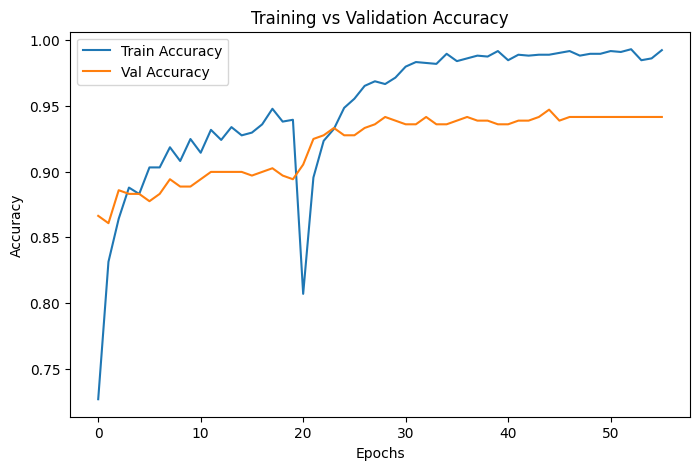

In [42]:
plt.figure(figsize=(8,5))
plt.plot(epochs, history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


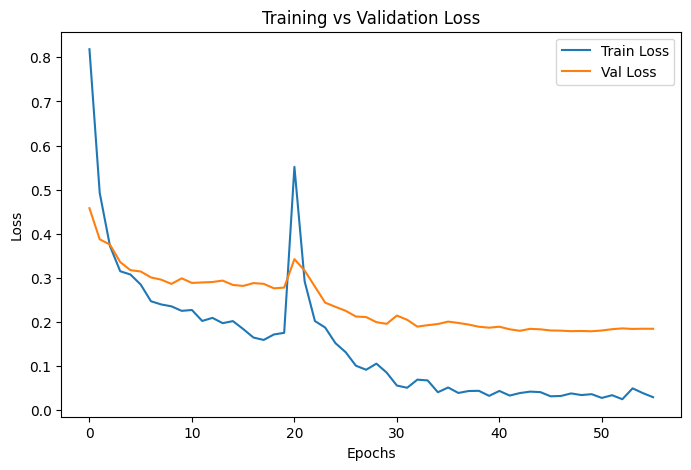

In [43]:
plt.figure(figsize=(8,5))
plt.plot(epochs, history["loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [44]:
pred = model.predict(val_generator)
pred_classes = np.argmax(pred, axis=1)
true_classes = val_generator.classes
target_names = list(train_generator.class_indices.keys())


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 631ms/step


In [45]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, pred_classes, target_names=target_names))


              precision    recall  f1-score   support

  clear skin       0.98      0.95      0.96       100
  dark spots       0.91      0.95      0.93        96
  puffy eyes       0.95      0.93      0.94        80
    wrinkles       0.93      0.94      0.93        83

    accuracy                           0.94       359
   macro avg       0.94      0.94      0.94       359
weighted avg       0.94      0.94      0.94       359



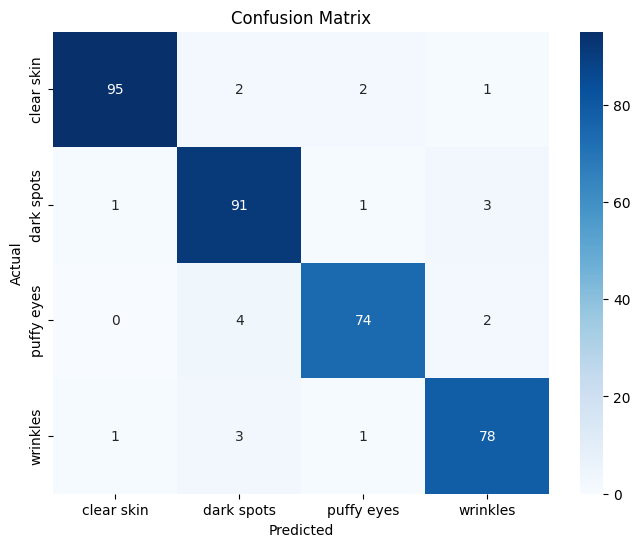

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [1]:
import sys, numpy
print("Python :", sys.version)
print("NumPy  :", numpy.__version__)


Python : 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
NumPy  : 1.26.4


In [3]:
!pip install "numpy<2.0" mediapipe==0.10.9 opencv-python --upgrade --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 55.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 28.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible

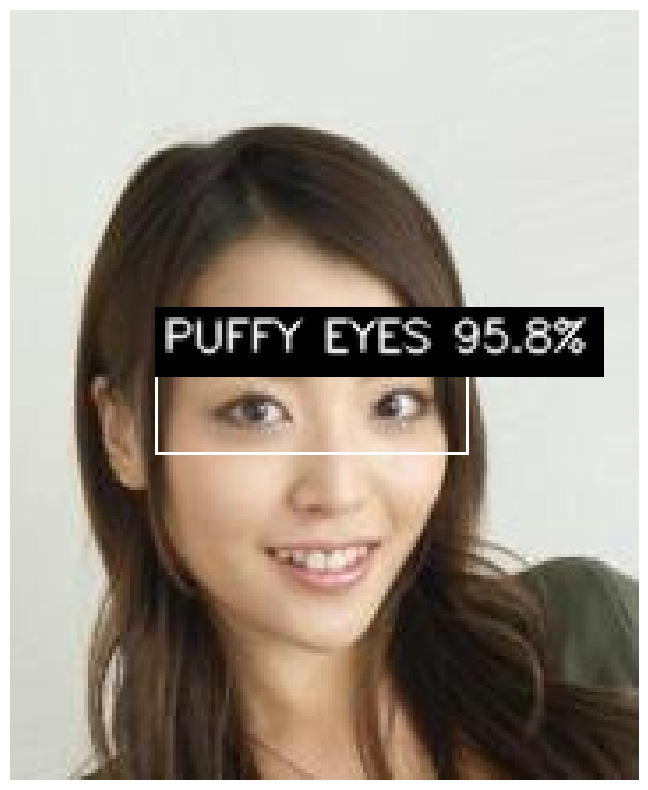

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

MODEL_PATH = '/kaggle/input/module-4/module_4/model/dermalscan_efficientnet_model.h5'
CASCADE_PATH = '/kaggle/input/module-4/module_4/haarcascade/haarcascade_frontalface_default.xml'
IMAGE_PATH = '/kaggle/input/module-4/module_4/test_images/008251.jpg'

class DermalScanner:
    def __init__(self, model_path, cascade_path):
        self.model = load_model(model_path)
        self.face_cascade = cv2.CascadeClassifier(cascade_path)
        self.class_names = ["wrinkles", "dark spots", "puffy eyes", "clear skin"]

    def classic_draw(self, img, text, rect, color=(255, 255, 255)):
 
        x, y, w, h = rect
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 1) 
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.4
        thickness = 1
        (t_w, t_h), _ = cv2.getTextSize(text, font, scale, thickness)
        
        cv2.rectangle(img, (x, y - t_h - 10), (x + t_w + 5, y), (0, 0, 0), -1)
        cv2.putText(img, text, (x + 2, y - 7), font, scale, color, thickness, cv2.LINE_AA)

    def get_prediction(self, roi):
        if roi is None or roi.size == 0: return 0, 0, 0, 0
        img_input = cv2.resize(roi, (224, 224))
        img_input = np.expand_dims(img_input, axis=0)
        img_input = preprocess_input(img_input.astype(np.float32))
        preds = self.model.predict(img_input, verbose=0)[0]
        return preds 

    def detect(self, image_path):
        img = cv2.imread(image_path)
        if img is None: return None
        output = img.copy()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(100, 100))

        if len(faces) == 0:
        
            faces = [(0, 0, img.shape[1], img.shape[0])]

        for (x, y, w, h) in faces:
            face_img = img[y:y+h, x:x+w]

            forehead_zone = face_img[int(0.05*h):int(0.3*h), int(0.2*w):int(0.8*w)]
        
            eye_zone = face_img[int(0.3*h):int(0.5*h), int(0.1*w):int(0.9*w)]

            lower_zone = face_img[int(0.5*h):int(0.9*h), int(0.15*w):int(0.85*w)]

            f_preds = self.get_prediction(forehead_zone)
            e_preds = self.get_prediction(eye_zone)
            l_preds = self.get_prediction(lower_zone)

            wrinkle_score = f_preds[0] * 100
            puffy_score = e_preds[2] * 100
            spot_score = l_preds[1] * 100

            total_deduction = 0
            if wrinkle_score > 70: total_deduction += (wrinkle_score * 0.3)
            if puffy_score > 70: total_deduction += (puffy_score * 0.3)
            if spot_score > 70: total_deduction += (spot_score * 0.3)
            
            clear_skin_score = max(0, 100 - total_deduction)
            active_boxes = 0

            if wrinkle_score > 75:
                self.classic_draw(output, f"WRINKLES {wrinkle_score:.1f}%", 
                                 (x+int(0.2*w), y+int(0.05*h), int(0.6*w), int(0.25*h)))
                active_boxes += 1

            if puffy_score > 75:
                self.classic_draw(output, f"PUFFY EYES {puffy_score:.1f}%", 
                                 (x+int(0.1*w), y+int(0.3*h), int(0.8*w), int(0.2*h)))
                active_boxes += 1

            if spot_score > 75:
                self.classic_draw(output, f"DARK SPOTS {spot_score:.1f}%", 
                                 (x+int(0.15*w), y+int(0.5*h), int(0.7*w), int(0.4*h)))
                active_boxes += 1

            if active_boxes == 0 or clear_skin_score > 85:
                if active_boxes == 0: 
                    self.classic_draw(output, f"CLEAR SKIN {clear_skin_score:.1f}%", (x, y, w, h), (180, 255, 180))

        return output

scanner = DermalScanner(MODEL_PATH, CASCADE_PATH)
final_view = scanner.detect(IMAGE_PATH)

if final_view is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(final_view, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

AGE : 28
WRINKLES  : 2.46%
PUFFY EYES: 95.79%
DARK SPOTS: 13.61%
CLEAR SKIN: 71.26%


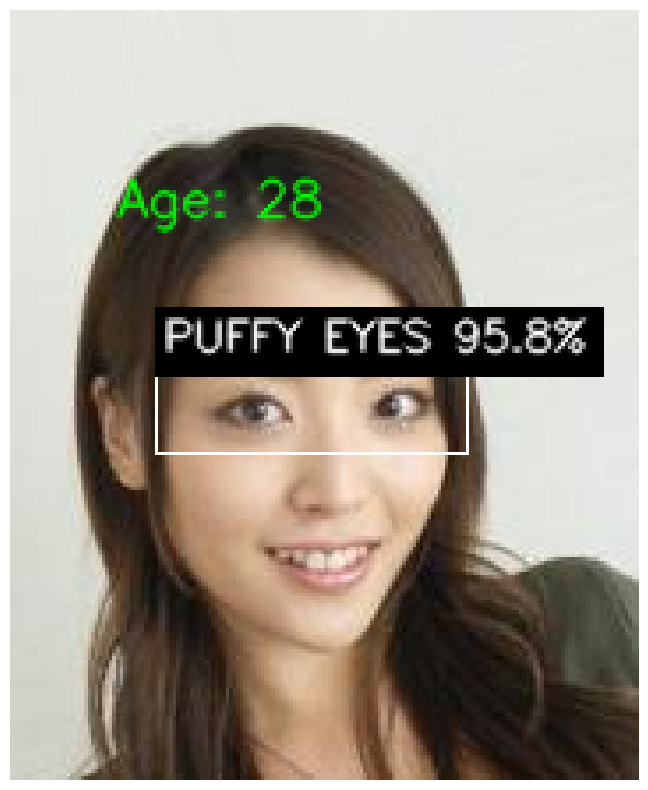

In [13]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

MODEL_PATH = "/kaggle/input/module-4/module_4/model/dermalscan_efficientnet_model.h5"
CASCADE_PATH = "/kaggle/input/module-4/module_4/haarcascade/haarcascade_frontalface_default.xml"
IMAGE_PATH = "/kaggle/input/module-4/module_4/test_images/008251.jpg"

AGE_PROTO = "/kaggle/input/opencv-files/age_deploy.prototxt"
AGE_MODEL = "/kaggle/input/opencv-files/age_net.caffemodel"

# MUST BE 8 VALUES ONLY
AGE_BUCKETS = [1, 5, 10, 18, 28, 36, 45, 60]

class DermalScanner:
    def __init__(self, model_path, cascade_path):
        self.model = load_model(model_path)
        self.face_cascade = cv2.CascadeClassifier(cascade_path)
        self.class_names = ["wrinkles", "dark_spots", "puffy_eyes", "clear_skin"]
        self.age_net = cv2.dnn.readNetFromCaffe(AGE_PROTO, AGE_MODEL)

    # ---------- AGE ESTIMATION ----------
    def estimate_age(self, face):
        blob = cv2.dnn.blobFromImage(face, 1.0, (227,227),
                                     (78.426,87.768,114.896))
        self.age_net.setInput(blob)
        preds = self.age_net.forward()[0]

        estimated_age = np.sum(preds * np.array(AGE_BUCKETS))
        return int(round(estimated_age))

    # ---------- NEAT BOX DRAW ----------
    def classic_draw(self, img, text, rect, color=(255, 255, 255)):
        x, y, w, h = rect
        cv2.rectangle(img,(x,y),(x+w,y+h),color,1)

        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.4
        thickness = 1
        (tw, th), _ = cv2.getTextSize(text,font,scale,thickness)

        cv2.rectangle(img,(x,y-th-10),(x+tw+5,y),(0,0,0),-1)
        cv2.putText(img,text,(x+2,y-7),
                    font,scale,color,thickness,cv2.LINE_AA)

    # ---------- CNN PRED ----------
    def get_prediction(self, roi):
        if roi is None or roi.size == 0:
            return [0,0,0,0]

        img_input = cv2.resize(roi,(224,224))
        img_input = np.expand_dims(img_input,axis=0)
        img_input = preprocess_input(img_input.astype(np.float32))
        preds = self.model.predict(img_input,verbose=0)[0]
        return preds

    # ---------- MAIN ----------
    def detect(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            print("Image not found")
            return None

        output = img.copy()
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        faces = self.face_cascade.detectMultiScale(
            gray,1.1,4,minSize=(100,100)
        )

        if len(faces) == 0:
            faces = [(0,0,img.shape[1],img.shape[0])]

        for (x,y,w,h) in faces:
            face_img = img[y:y+h, x:x+w]

            # AGE
            age = self.estimate_age(face_img)

            cv2.putText(
                output,
                f"Age: {age}",
                (x, y-12 if y>20 else y+h+18),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.48,
                (0,255,0),
                1,
                cv2.LINE_AA
            )

            # ZONES
            forehead_zone = face_img[int(0.05*h):int(0.3*h), int(0.2*w):int(0.8*w)]
            eye_zone      = face_img[int(0.3*h):int(0.5*h), int(0.1*w):int(0.9*w)]
            lower_zone    = face_img[int(0.5*h):int(0.9*h), int(0.15*w):int(0.85*w)]

            f_preds = self.get_prediction(forehead_zone)
            e_preds = self.get_prediction(eye_zone)
            l_preds = self.get_prediction(lower_zone)

            wrinkle_score = f_preds[0] * 100
            puffy_score   = e_preds[2] * 100
            spot_score    = l_preds[1] * 100

            total_deduction = 0
            if wrinkle_score > 70: total_deduction += wrinkle_score * 0.3
            if puffy_score > 70: total_deduction += puffy_score * 0.3
            if spot_score > 70: total_deduction += spot_score * 0.3

            clear_skin_score = max(0, 100 - total_deduction)

            print("AGE :", age)
            print(f"WRINKLES  : {wrinkle_score:.2f}%")
            print(f"PUFFY EYES: {puffy_score:.2f}%")
            print(f"DARK SPOTS: {spot_score:.2f}%")
            print(f"CLEAR SKIN: {clear_skin_score:.2f}%")

            active_boxes = 0

            if wrinkle_score > 75:
                self.classic_draw(output,
                    f"WRINKLES {wrinkle_score:.1f}%",
                    (x+int(0.2*w), y+int(0.05*h),
                     int(0.6*w), int(0.25*h)))
                active_boxes += 1

            if puffy_score > 75:
                self.classic_draw(output,
                    f"PUFFY EYES {puffy_score:.1f}%",
                    (x+int(0.1*w), y+int(0.3*h),
                     int(0.8*w), int(0.2*h)))
                active_boxes += 1

            if spot_score > 75:
                self.classic_draw(output,
                    f"DARK SPOTS {spot_score:.1f}%",
                    (x+int(0.15*w), y+int(0.5*h),
                     int(0.7*w), int(0.4*h)))
                active_boxes += 1

            if active_boxes == 0 or clear_skin_score > 85:
                if active_boxes == 0:
                    self.classic_draw(output,
                        f"CLEAR SKIN {clear_skin_score:.1f}%",
                        (x,y,w,h),(180,255,180))

        return output


scanner = DermalScanner(MODEL_PATH, CASCADE_PATH)
final_view = scanner.detect(IMAGE_PATH)

if final_view is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(final_view,cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
